# Peach classification
Can we classify what cats are Peach (and not Peach)? Trying to get my ML skills up :3

Tutorial/foundation steps provided [here](https://dilithjay.com/blog/custom-image-classifier-with-pytorch#2-define-the-datasets-and-dataloaders)

**Documentation used**:
1.   [SciKit Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
2.   [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html)
3.   [PyTorch pre-trained models](https://pytorch.org/vision/main/models.html)

In [50]:
!pip install torch torchvision

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import pandas as pd

## Creating/transforming data

Make sure `data.zip` is imported to Colab before running anything!!

In [11]:
# Resizing, converting to tensor, and normalizing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [12]:
!unzip data.zip

Archive:  data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [14]:
train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

## Testing to see if split worked okay :3

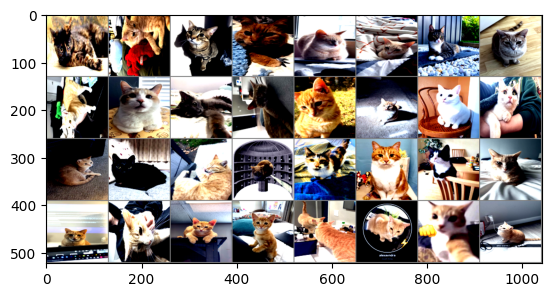

not peach peach not peach not peach


In [21]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter) # Use next(dataiter) instead of dataiter.next()

# Show images
imshow(make_grid(images))

# Print labels
print(' '.join(f'{train_dataset.classes[labels[j]]}' for j in range(4)))

## Classification time!

In [22]:
from torchvision.models import resnet50, ResNet50_Weights

In [23]:
# From PyTorch Docs
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 110MB/s]


In [24]:
# 2 classes because of 'Peach' and 'Not Peach' classifications in dataset
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 2)
)

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

### Function and loss optimizer

In [28]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Training classifier

In [29]:
metrics = {
    'train': {
         'loss': [], 'accuracy': []
    },
    'val': {
         'loss': [], 'accuracy': []
    },
}

In [33]:
dataloaders = {
    'train': train_loader,
    'val': test_loader
}

# Low epoch range because 30 is high right now lol
for epoch in range(10):
    ep_metrics = {
        'train': {'loss': 0, 'accuracy': 0, 'count': 0},
        'val': {'loss': 0, 'accuracy': 0, 'count': 0},
    }

    print(f'Epoch {epoch}')

    for phase in ['train', 'val']:
        print(f'-------- {phase} --------')
        for images, labels in dataloaders[phase]:
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                output = model(images.to(device))

                # Use labels directly without one-hot encoding
                loss = criterion(output, labels.to(device))

                correct_preds = labels.to(device) == torch.argmax(output, dim=1)
                accuracy = (correct_preds).sum().item() / len(labels)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            ep_metrics[phase]['loss'] += loss.item()
            ep_metrics[phase]['accuracy'] += accuracy
            ep_metrics[phase]['count'] += 1

        ep_loss = ep_metrics[phase]['loss'] / ep_metrics[phase]['count']
        ep_accuracy = ep_metrics[phase]['accuracy'] / ep_metrics[phase]['count']

        print(f'Loss: {ep_loss}, Accuracy: {ep_accuracy}\n')

        metrics[phase]['loss'].append(ep_loss)
        metrics[phase]['accuracy'].append(ep_accuracy)

Epoch 0
-------- train --------
Loss: 0.5755503475666046, Accuracy: 0.90625

-------- val --------
Loss: 0.6844880878925323, Accuracy: 0.6160714285714286

Epoch 1
-------- train --------
Loss: 0.542454719543457, Accuracy: 0.9174107142857143

-------- val --------
Loss: 0.6857368350028992, Accuracy: 0.6116071428571428

Epoch 2
-------- train --------
Loss: 0.48689307272434235, Accuracy: 1.0

-------- val --------
Loss: 0.6825312077999115, Accuracy: 0.5825892857142857

Epoch 3
-------- train --------
Loss: 0.4590310752391815, Accuracy: 0.9642857142857143

-------- val --------
Loss: 0.6801905035972595, Accuracy: 0.5714285714285714

Epoch 4
-------- train --------
Loss: 0.43651625514030457, Accuracy: 0.9508928571428572

-------- val --------
Loss: 0.6854757964611053, Accuracy: 0.5491071428571428

Epoch 5
-------- train --------
Loss: 0.39467206597328186, Accuracy: 1.0

-------- val --------
Loss: 0.6876989603042603, Accuracy: 0.5491071428571428

Epoch 6
-------- train --------
Loss: 0.359

### Visualization of metrics from epochs

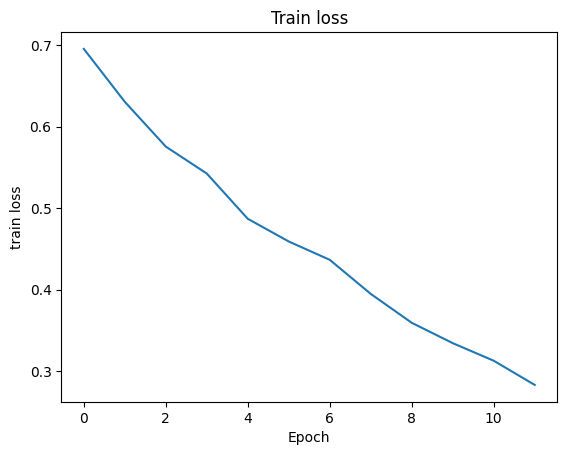

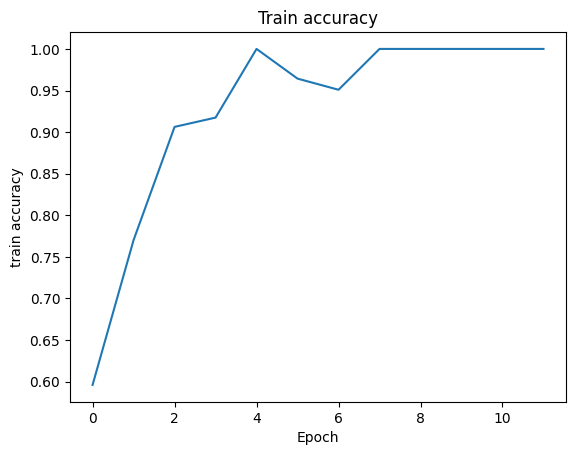

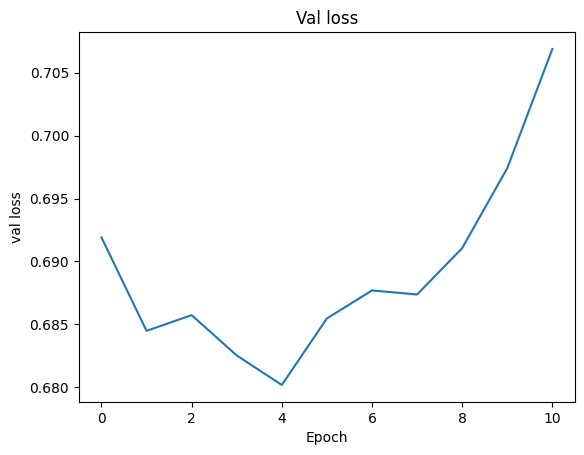

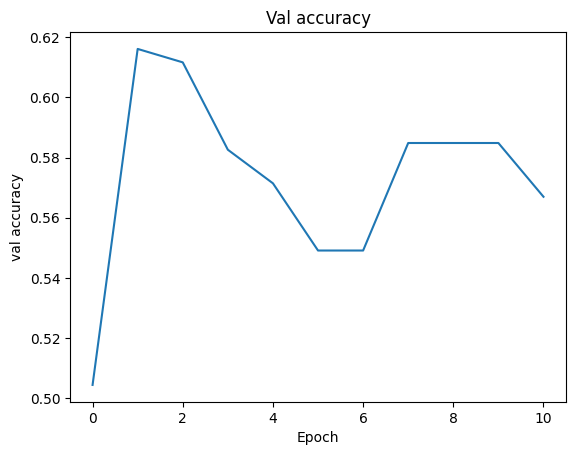

In [38]:
for phase in metrics:
    for metric in metrics[phase]:
        metric_data = metrics[phase][metric]
        plt.plot(range(len(metric_data)), metric_data)
        plt.title(f'{phase.capitalize()} {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(f'{phase} {metric}')
        plt.show()

## Testing the classifier model

In [41]:
!pip install tqdm

In [42]:
import torch
import torch.nn as nn
from tqdm import tqdm

NUM_CLASSES = 2

preds = []
actual = []

tot_loss = tot_acc = count = 0

for images, labels in tqdm(dataloaders['val']):  # Assuming 'val' is your test set loader
    with torch.set_grad_enabled(False):
        output = model(images.to(device))
        out_labels = torch.argmax(output, dim=1)

        # Use labels directly without one-hot encoding
        loss = criterion(output, labels.to(device))
        tot_loss += loss.item()
        tot_acc += (labels.to(device) == out_labels).sum().item() / len(labels)
        count += 1

    preds += out_labels.tolist()
    actual += labels.tolist()

print(f"Test Loss: {tot_loss / count}, Test Accuracy: {tot_acc / count}")

100%|██████████| 2/2 [00:22<00:00, 11.30s/it]

Test Loss: 0.7068901360034943, Test Accuracy: 0.5669642857142857


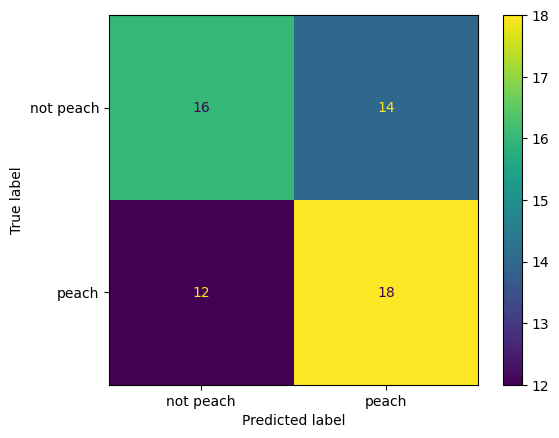

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extract class labels from the ImageFolder dataset
class_labels = test_dataset.classes

cm = confusion_matrix(actual, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot()
plt.show()

In [49]:
cm_np = np.array(cm)
stats = pd.DataFrame(index=class_labels)
stats['Precision'] = [cm_np[i, i]/np.sum(cm_np[:, i]) for i in range(len(cm_np))]
stats['Recall'] = [cm_np[i, i]/np.sum(cm_np[i, :]) for i in range(len(cm_np))]
stats

,Precision,Recall
not peach,0.571429,0.533333
peach,0.562500,0.600000
